Coded by Lujia Zhong @lujiazho<br>
Reference: https://github.com/amdegroot/ssd.pytorch

Note: 
1. 0 for background (no object), 1-91 for COCO-defined thing categories.
2. `ceil_mode` warning is annoying in Pytorch 1.11.0, which appears when `ceil_mode != return_indices`. I change it locally so it won't appear. This warning doesn't affect any training or inference of model.

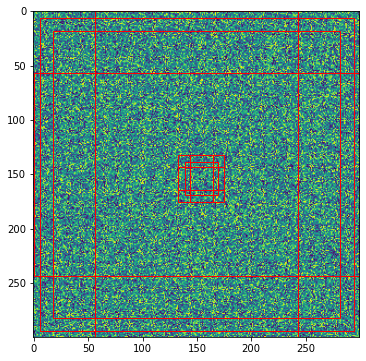

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def prior_boxes():
    """Generating default boxes: [center_x, center_y, w, h] in range of [0, 1]
    """
    feature_size = [38, 19, 10, 5, 3, 1]

    # small square box ratio: s_k
    min_sizes = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88]
    # s_(k+1)
    max_sizes = [0.2, 0.37, 0.54, 0.71, 0.88, 1.05]

    # aspect ratio except for small square and big square
    aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]

    boxes = []
    for k, f in enumerate(feature_size):
        for i in range(f):
            for j in range(f):
                cx = (j + 0.5) / f
                cy = (i + 0.5) / f

                # small square box with aspect ratio: 1
                s_k = min_sizes[k]
                boxes.append([cx, cy, s_k, s_k])

                # big square box with aspect ratio: 1'
                s_k_prime = (s_k * max_sizes[k])**0.5
                boxes.append([cx, cy, s_k_prime, s_k_prime])

                # rest of aspect ratios
                for ar in aspect_ratios[k]:
                    sqrt_ar = ar**0.5
                    boxes.append([cx, cy, s_k*sqrt_ar, s_k/sqrt_ar])
                    boxes.append([cx, cy, s_k/sqrt_ar, s_k*sqrt_ar])

    return np.clip(np.array(boxes), a_min=0, a_max=1)

default_boxes = prior_boxes()

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)

_ = ax.imshow(np.random.rand(300, 300))

for i, rec in enumerate(np.concatenate((default_boxes[741*4:741*4+4], default_boxes[-4:]), axis=0)):
    x_c, y_c, w, h = rec
    x_c, y_c, w, h = x_c.item(), y_c.item(), w.item(), h.item()
    xy = ((x_c-w/2)*300, (y_c-h/2)*300)
    w, h = w*300, h*300
    
    ax.add_patch(Rectangle(xy, w, h, linewidth=1, edgecolor='r', facecolor='None'))

In [2]:
import torch
import torch.nn as nn

################################################################################################
#                                           VGG Part                                           #
################################################################################################

class L2Norm(nn.Module):
    """L2 Normalization.
    """
    def __init__(self,n_channels):
        super(L2Norm,self).__init__()

        self.weight = nn.Parameter(torch.Tensor(n_channels))
        self.weight.data.fill_(20) # scale to 20 initially as mentioned in paper

    def forward(self, x):
        # torch.Size([1, 512, 38, 38])
        
        # l2 normalization at dimension 2 (channel)
        x = torch.nn.functional.normalize(x, p=2, dim=1)  # torch.Size([1, 512, 38, 38])
        
        # torch.Size([512]) -> torch.Size([1, 512, 1, 1])
        return self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3) * x

class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
                                    nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.block2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
                                    nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.block3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
                                    nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(), 
                                    nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True))
        
        self.block4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(),
                                    nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(), 
                                    nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU())
        self.L2Norm = L2Norm(512)
        self.block4_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.block5 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
                                    nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(), 
                                    nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=3, stride=1, padding=1))

        # FC layers, changed to conv as mentioned in paper
        self.conv6 = nn.Sequential(nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6), nn.ReLU())
        self.conv7 = nn.Sequential(nn.Conv2d(1024, 1024, kernel_size=1), nn.ReLU())

    def forward(self, x):
        # torch.Size([B, 3, 300, 300])
        assert x.shape[1] == 3, "Unsupported input channel."
        assert x.shape[-2] == 300 and x.shape[-1] == 300, "Unsupported image size."
        
        feature_maps = []
        
        x = self.block1(x)       # torch.Size([B, 64, 150, 150])
        x = self.block2(x)       # torch.Size([B, 128, 75, 75])
        x = self.block3(x)       # torch.Size([B, 256, 38, 38])
        x = self.block4(x)
        feature_maps.append(self.L2Norm(x))
        
        x = self.block4_pool(x)  # torch.Size([B, 512, 19, 19])
        x = self.block5(x)       # torch.Size([B, 512, 19, 19])

        x = self.conv6(x)          # torch.Size([B, 1024])
        x = self.conv7(x)          # torch.Size([B, 1024])
        feature_maps.append(x)
        
        return x, feature_maps


################################################################################################
#                                          LOSS Part                                           #
################################################################################################

class Criterion(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.num_classes = num_classes        
        self.threshold = 0.5           # as mentioned in paper
        self.negpos_ratio = 3          # as mentioned in paper
        self.variance = [0.1, 0.2]     # as mentioned in paper

    def forward(self, predictions, targets):
        """Multibox Loss
            predictions:
                loc_data: torch.Size([Batch, 8732, 4]), offset pred
                conf_data: torch.Size([Batch, 8732, num_classes]), class pred
                priors: torch.Size([8732, 4])
            targets: [batch, torch.Size([num_objs, 5])]
        """
        loc_data, conf_data, priors = predictions
        batch_size = loc_data.shape[0]
        
        assert priors.shape[0] == 8732, "Not valid."
        
        # match priors (default boxes) and ground truth boxes
        loc_t = torch.Tensor(batch_size, 8732, 4)
        class_t = torch.LongTensor(batch_size, 8732)
        
        for idx in range(batch_size):
            truths = targets[idx][:, :-1]
            labels = targets[idx][:, -1]
            
            # get matched gt and according class for each prior
            matches, cls_t = self.match(self.threshold, truths, priors, labels)
            
            # encoded offset of location (loc_diff) is our loc target: [diff_x_c, diff_y_c, diff_w, diff_h]
            loc_diff = self.encode(matches, priors, self.variance)
            loc_t[idx], class_t[idx] = loc_diff, cls_t
        
        # calc numbers of priors that have detected objects (positive samples), must be in [num_objs, 8732]
        positive_mask = class_t > 0
        
        # [batch, 8732] -> [batch, 8732, 1] - > [batch, 8732, 4]
        pos_idx = positive_mask.unsqueeze(positive_mask.dim()).expand_as(loc_data)
        # only keeps those priors that have detected objects (likely many-to-one)
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)
        # Localization Loss (Smooth L1), only for positive samples
        loss_loc = torch.nn.functional.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # get loss of classes for all priors across batch
        loss_c = nn.functional.cross_entropy(conf_data.view(-1, self.num_classes), 
                                             class_t.view(-1), reduction='none')
        loss_c = loss_c.view(batch_size, -1)
        # set positive samples' classes loss to 0 for now for Hard Negative Mining
        loss_c[positive_mask] = 0
        
        # Hard Negative Mining
        _, loss_idx = loss_c.sort(1, descending=True)   # first sort: get idx of losses
        _, idx_rank = loss_idx.sort(1)                  # second sort: get rank of losses in original array
        
        num_positive = positive_mask.sum(1, keepdim=True)
        num_negative = torch.clamp(self.negpos_ratio*num_positive, max=8731)
        negative_mask = idx_rank < num_negative         # get negative samples mask

        # torch.Size([B, 8732]) -> torch.Size([B, 8732, 1]) -> torch.Size([B, 8732, num_classes])
        conf_pos_mask = positive_mask.unsqueeze(2).expand_as(conf_data)
        conf_neg_mask = negative_mask.unsqueeze(2).expand_as(conf_data)
        # get overall predicted confidence according to positive & negative samples
        conf_pred = conf_data[conf_pos_mask+conf_neg_mask].view(-1, self.num_classes)
        # get overall target confidence according to positive & negative samples
        conf_targets = class_t[positive_mask+negative_mask]
        # get loss of classes
        loss_cls = torch.nn.functional.cross_entropy(conf_pred, conf_targets, reduction='sum')

        N = num_positive.sum()                           # total positive number across batch

        return loss_loc / N, loss_cls / N
    
    def IOU(self, box_a, box_b):
        """so called jaccard overlap in the paper
            box_a: torch.Size([num_of_objs, 4])
            box_b: torch.Size([8732, 4]) priors boxes
        """
        max_xy = torch.min(box_a[:, 2:].unsqueeze(1), box_b[:, 2:].unsqueeze(0))
        min_xy = torch.max(box_a[:, :2].unsqueeze(1), box_b[:, :2].unsqueeze(0))
        inter = torch.clamp((max_xy - min_xy), min=0)
        interArea = inter[:, :, 0] * inter[:, :, 1]

        area_a = ((box_a[:, 2]-box_a[:, 0]) * (box_a[:, 3]-box_a[:, 1])).unsqueeze(1)
        area_b = ((box_b[:, 2]-box_b[:, 0]) * (box_b[:, 3]-box_b[:, 1])).unsqueeze(0)
        union = area_a + area_b - interArea

        # torch.Size([num_of_objs, 8732])
        return interArea / union

    def match(self, threshold, truths, priors, labels):
        """Match priors to ground truth, ensuring each gt has been matched by at least one prior
        """
        overlaps = self.IOU(
            truths,
            # (center_x, center_y, w, h) -> (x_min, y_min, x_max, y_max)
            torch.cat((priors[:, :2] - priors[:, 2:]/2, priors[:, :2] + priors[:, 2:]/2), 1)
        )

        # best prior for each ground truth: torch.Size([num_of_objs]) torch.Size([num_of_objs])
        _, best_prior_idx = overlaps.max(1)
        # best ground truth for each prior: torch.Size([8732]) torch.Size([8732])
        best_truth_overlap, best_truth_idx = overlaps.max(0)

        # make sure each ground truth has been match by as least one prior
        for j in range(best_prior_idx.shape[0]):
            best_truth_idx[best_prior_idx[j]] = j

        # get best ground truth match of each prior
        loc_target = truths[best_truth_idx]                          # [8732, 4]
        # real labels in [1, num_classes-1], because num_classes includes background (0)
        class_target = labels[best_truth_idx]                        # [8732]

        # in case that all conf is under threshold, set best priors' IOU as 1
        best_truth_overlap.index_fill_(0, best_prior_idx, 1)
        # label as background (0) if conf < threshold, else consider it as positive sample
        class_target[best_truth_overlap < threshold] = 0

        # [8732, 4], [8732]
        return loc_target, class_target
    
    def encode(self, matched, priors, variances):
        """x1,y1,x2,y2 -> offset and Encode the variances into the location offset
            matched: in form of [x_min, y_min, x_max, y_max] at range of (0, 1)
            priors: in form of [x_center, y_center, w, h] at range of (0, 1)
        """
        # difference of center location
        diff_center = ((matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]) / priors[:, 2:]
        # encode center variance
        diff_center /= variances[0]

        # difference of w & h
        diff_wh = torch.log((matched[:, 2:] - matched[:, :2]) / priors[:, 2:])
        # encode size variance
        diff_wh /= variances[1]

        # return for smooth_l1_loss
        return torch.cat([diff_center, diff_wh], 1)  # [8732, 4]


################################################################################################
#                                          SSD Part                                            #
################################################################################################

class SSD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        assert num_classes == 92, f"Not equal to COCO's classes number."
        
        # SSD network
        self.vgg16 = VGG16()
        
        self.extras = nn.ModuleList([
            nn.Sequential(nn.Conv2d(1024, 256, kernel_size=1, stride=1), nn.ReLU(),
                          nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), nn.ReLU()),
            
            nn.Sequential(nn.Conv2d(512, 128, kernel_size=1, stride=1), nn.ReLU(),
                          nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), nn.ReLU()),
            
            nn.Sequential(nn.Conv2d(256, 128, kernel_size=1, stride=1), nn.ReLU(),
                          nn.Conv2d(128, 256, kernel_size=3, stride=1), nn.ReLU()),
            
            nn.Sequential(nn.Conv2d(256, 128, kernel_size=1, stride=1), nn.ReLU(),
                          nn.Conv2d(128, 256, kernel_size=3, stride=1), nn.ReLU())
        ])

        self.loc = nn.ModuleList([
            nn.Conv2d(512, 16, kernel_size=3, stride=1, padding=1), 
            nn.Conv2d(1024, 24, kernel_size=3, stride=1, padding=1), 
            nn.Conv2d(512, 24, kernel_size=3, stride=1, padding=1), 
            nn.Conv2d(256, 24, kernel_size=3, stride=1, padding=1), 
            nn.Conv2d(256, 16, kernel_size=3, stride=1, padding=1), 
            nn.Conv2d(256, 16, kernel_size=3, stride=1, padding=1)
        ])
        self.conf = nn.ModuleList([
            nn.Conv2d(512, 4*num_classes, kernel_size=3, stride=1, padding=1), 
            nn.Conv2d(1024, 6*num_classes, kernel_size=3, stride=1, padding=1), 
            nn.Conv2d(512, 6*num_classes, kernel_size=3, stride=1, padding=1), 
            nn.Conv2d(256, 6*num_classes, kernel_size=3, stride=1, padding=1), 
            nn.Conv2d(256, 4*num_classes, kernel_size=3, stride=1, padding=1), 
            nn.Conv2d(256, 4*num_classes, kernel_size=3, stride=1, padding=1)
        ])

    def forward(self, x):
        assert x.shape[-2:] == (300, 300), "Not Supported input size."
        B = x.shape[0]
        
        # VGG16 base
        x, feats = self.vgg16(x)   # [B, 1024, 19, 19]
        
        # extra layers
        for extra in self.extras:
            x = extra(x)
            feats.append(x)
        
        # localization and classes head
        loc, conf = [], []
        for (x, l, c) in zip(feats, self.loc, self.conf):
            loc.append(l(x).permute(0, 2, 3, 1).contiguous().view(B, -1))
            conf.append(c(x).permute(0, 2, 3, 1).contiguous().view(B, -1))

        loc = torch.cat(loc, 1).view(B, -1, 4)
        conf = torch.cat(conf, 1).view(B, -1, self.num_classes)

        return (loc, conf)

num_classes = 92
model = SSD(num_classes=num_classes)

In [3]:
def gen_targets(batch_size):
    """Generate target objects: boxes (x_min,y_min,x_max,y_max) in [0, 1] and classes in [1, 92)
    """
    targets = []
    for _ in range(batch_size):
        num_ = torch.randint(1,100,(1,))
        x1y1 = torch.rand(num_, 2)
        targets.append(torch.concat((torch.clamp(torch.concat((x1y1-0.1, x1y1+0.1), dim=1), min=0, max=1.0), 
                                                  torch.randint(1, num_classes, (num_,1))), dim=1))
    return targets

criterion = Criterion(num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

batch_size = 2
iterarions = 2
begin = time.time()

# Training
for iterarion in range(iterarions):
    optimizer.zero_grad()
    priors = torch.from_numpy(default_boxes)
    targets = gen_targets(batch_size)
    
    pred_loc_offset, pred_cls_conf = model(torch.rand(batch_size, 3, 300, 300))
    
    loss_l, loss_c = criterion((pred_loc_offset, pred_cls_conf, priors), targets)
    losses = loss_l + loss_c

    if iterarion % 1 == 0:
        print('Iterarion:', '%2d,' % (iterarion + 1), 'loss =', '{:.4f}'.format(losses))

    losses.backward()
    optimizer.step()
print(f"{(time.time() - begin)/iterarions:.4f}s / iterarion")

Iterarion:  1, loss = 23.5542
Iterarion:  2, loss = 22.0271
2.7381s / iterarion


In [4]:
################################################################################################
#                                        Predict Part                                          #
################################################################################################

class Detect():
    def __init__(self, num_classes, top_k, conf_thresh, nms_thresh):
        self.num_classes = num_classes
        self.top_k = top_k
        
        self.conf_thresh = conf_thresh
        self.nms_thresh = nms_thresh
        assert 0 < nms_thresh < 1, 'Invalid nms_threshold.'
        
        self.variance = [0.1, 0.2]

    def forward(self, loc_data, conf_data, prior_data):
        """Decode and NMS
            loc_data: predicted encoded offset, [batch, 8732, 4]
            conf_data: predicted classes prob, [batch, 8732, num_classes]
            prior_data: [8732, 4]
        """
        batch_size = loc_data.shape[0]
        num_priors = prior_data.shape[0]
        assert num_priors == 8732, "Invalid priors number."
        
        output = torch.zeros(batch_size, self.num_classes, self.top_k, 5)
        # [batch, 8732, num_classes] -> [batch, num_classes, 8732] for class-wise NMS
        conf_preds = conf_data.transpose(2, 1)

        # Decode predictions into bboxes.
        for i in range(batch_size):
            decoded_boxes = self.decode(loc_data[i], prior_data, self.variance)
            
            # For each class, perform nms (here we don't care if this class has highest conf for each pred box)
            # Of course we can also first pickout the highest conf for 8732 boxes, leading to less computation
            for cls_ in range(1, self.num_classes):
                thresh_mask = conf_preds[i][cls_]>self.conf_thresh # [8732]
                
                if torch.sum(thresh_mask) == 0: # no valid confidence
                    continue
                    
                scores = conf_preds[i][cls_][thresh_mask]                
                boxes = decoded_boxes[thresh_mask]

                # idx of highest scoring and non-overlapping boxes per class
                idx, count = self.nms(boxes, scores, self.nms_thresh, self.top_k)
                # detected boxes are keep in front for each class
                output[i, cls_, :count] = torch.cat((scores[idx].unsqueeze(1), boxes[idx]), 1)

        # only keep top_k boxes at most in total across classes for each batch
        output = output.contiguous().view(batch_size, -1, 5)
        _, idx = output[:, :, 0].sort(1, descending=True)
        _, rank = idx.sort(1)
        output[(rank >= self.top_k).unsqueeze(-1).expand_as(output)] = 0

        return output.view(batch_size, self.num_classes, self.top_k, 5)
    
    def decode(self, loc, priors, variances):
        """Decode locations out of predictions from priors and variance to offset, then get x1,x2,y1,y2
            loc: predicted encoded offset, [num_priors, 4]
            priors: [center_x, center_y, w, h] in range of [0, 1], [num_priors,4]
            variances: pre-defined scale parameter for location
        """
        # get absolute location x_center,x_center,w,h at range of (0, 1)
        boxes = torch.cat((priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:],
                           priors[:, 2:] * torch.exp(loc[:, 2:] * variances[1])), 1)
        # get x1,x2,y1,y2 at range of (0, 1), in practial it may be less than 0 because of not being trained well
        boxes[:, :2] -= boxes[:, 2:] / 2
        boxes[:, 2:] += boxes[:, :2]
        return boxes
    
    def nms(self, boxes, scores, overlap=0.5, top_k=200):
        """NMS: Non-Maximum Suppression
            boxes: decoded location [x_min, y_min, x_max, y_max], [num_priors, 4]
            scores: classes prediction, [num_priors]
            overlap: IOU threshold for NMS
            top_k: The maximum number of boxes to keep
        """
        assert boxes.shape[0] == scores.shape[0], "Not matched perdicts."

        keep = []
        if scores.numel() == 0: # in case there is no object
            return torch.tensor(keep), 0

        # get area of each boxes
        x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
        area = (x2-x1)*(y2-y1)

        _, idx = scores.sort()   # sort in ascending order
        idx = idx[-top_k:]       # indices of the top-k largest vals

        # numel: total number of elements
        while idx.numel() > 0:
            i = idx[-1]          # index of current largest val
            keep.append(i)

            if idx.size(0) == 1:
                break
            idx = idx[:-1]       # remove largest val's idx

            # get intersect boxes
            inter_box = torch.clamp(boxes[idx], 
                              min=torch.tensor([x1[i], y1[i], 0, 0]),
                              max=torch.tensor([1, 1, x2[i], y2[i]]))
            # get inter w & h
            w = torch.clamp(inter_box[:, 2] - inter_box[:, 0], min=0.0)
            h = torch.clamp(inter_box[:, 3] - inter_box[:, 1], min=0.0)
            # get inter area
            inter_area = w*h

            box_areas = area[idx]

            union = box_areas + area[i] - inter_area
            iou = inter_area/union

            # keep only elements with an IoU <= overlap
            idx = idx[iou<=overlap]

        return torch.tensor(keep), len(keep)

# for classes number = 92, 0.02 is still not bad confidence
detector = Detect(num_classes, 200, 0.02, 0.45)

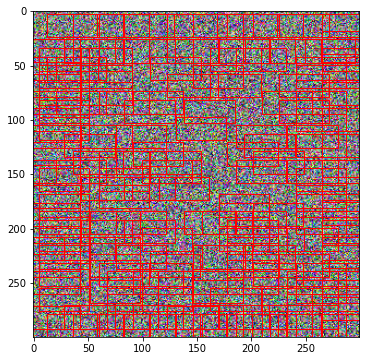

In [5]:
# SSD forward
img = torch.rand(1, 3, 300, 300)
pred_loc_offset, pred_cls_conf = model(img)
# Decode, and NMS
detections = detector.forward(pred_loc_offset, torch.nn.functional.softmax(pred_cls_conf, dim=-1), priors)

classes, confs, boxes = [], [], []
for i in range(1, num_classes):
    j = 0
    while detections[0, i, j, 0] >= 0.033:
        classes.append(i)
        confs.append(detections[0, i, j, 0].item())
        boxes.append((detections[0, i, j, 1:]*300).detach().numpy())
        j += 1

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)

_ = ax.imshow(img[0].permute(1, 2, 0))

for i, cls_conf_box in enumerate(zip(classes, confs, boxes)):
    cls_, conf, (x1, y1, x2, y2) = cls_conf_box
    w, h = x2-x1, y2-y1
    ax.add_patch(Rectangle((x1,y1), w, h, linewidth=1, edgecolor='r', facecolor='None'))